# Description - Create Figures regarding the Spectrogram Analyses

The primary outputs of this notebook include:

* Figure 3: Representative subject and description of the spectrogram analyses

# Import Libraries

In [1]:
import os
import pandas as pd
import numpy  as np
import os.path as osp
from utils.variables import DATA_DIR
from utils.basics import get_available_runs

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import hvplot.pandas

%matplotlib inline

# Analysis Configuration Variables

In [2]:
region             = 'V4_grp' # Use the Group-Level FV ROI
spectrogram_windur = 60       # Spectrogram Window Duration (In seconds)
Nacq               = 890      # Number of acquisitions

# Generate Time Index for Windowed Results

Having these two indexes will help us plot original data and windowed frequency information in a way that aligns visually and helps with interpretation

In [3]:
# First we generate a regular time index (the one that corresponds to the fMRI TR)
time_index         = pd.timedelta_range(start='0 s', periods=Nacq, freq='s')
print('++ Time Index (first 10 values):')
print(time_index[0:10])

++ Time Index (first 10 values):
TimedeltaIndex(['0 days 00:00:00', '0 days 00:00:01', '0 days 00:00:02',
                '0 days 00:00:03', '0 days 00:00:04', '0 days 00:00:05',
                '0 days 00:00:06', '0 days 00:00:07', '0 days 00:00:08',
                '0 days 00:00:09'],
               dtype='timedelta64[ns]', freq='S')


In [4]:
# Create empty dataframe with index having time_delta in steps of seconds
aux = pd.DataFrame(np.ones(Nacq),index=time_index)
# Simulate rolling windows of spectrogram_windur to gather which index should have data
aux                    = aux.rolling(window=spectrogram_windur, center=True).mean()
aux                    = aux.dropna()
windowed_time_index    = aux.index
print('++ Window Index (first 10 values):')
print(windowed_time_index[0:10])

++ Window Index (first 10 values):
TimedeltaIndex(['0 days 00:00:30', '0 days 00:00:31', '0 days 00:00:32',
                '0 days 00:00:33', '0 days 00:00:34', '0 days 00:00:35',
                '0 days 00:00:36', '0 days 00:00:37', '0 days 00:00:38',
                '0 days 00:00:39'],
               dtype='timedelta64[ns]', freq='S')


*** 
# Figure 3: Explanation of Spectrogram Analyses

This figure is used to explain this part of the analysis on the manuscript. We selected a subject that kept eyes open during the first half of the scan, and then closed eyes later during the second part

In [5]:
# Representative run
sample_run = '283543_rfMRI_REST1_PA'
sbj, run   = sample_run.split('_',1)
# Paths to all necessary outputs for this run
roi_path            = osp.join(DATA_DIR,sbj,run,'{RUN}_mPP.Signal.{REGION}.1D'.format(RUN=run, REGION=region))
spectrogram_path    = osp.join(DATA_DIR,sbj,run,'{RUN}_mPP.Signal.{REGION}.Spectrogram.pkl'.format(RUN=run, REGION=region))
spectrogram_bl_path = osp.join(DATA_DIR,sbj,run,'{RUN}_mPP.Signal.{REGION}.Spectrogram_BandLimited.pkl'.format(RUN=run, REGION=region))
motion_fd_path      = osp.join(DATA_DIR,sbj,run,'{RUN}_Movement_FD.txt'.format(RUN=run))
motion_reg_path     = osp.join(DATA_DIR,sbj,run,'{RUN}_Movement_Regressors.discard10.txt'.format(RUN=run))
# Load all results into memory
sample_spectrogram_df = pd.read_pickle(spectrogram_path)
sample_spectrogram_bl_df = pd.read_pickle(spectrogram_bl_path)
sample_roi_df = pd.DataFrame(np.loadtxt(roi_path),index=time_index,columns=['ROI TS'])

In addition to the original timeseries and its spectral properties, we will also load and inspect eye tracking information and motion

* Load/Plot framewise displacement, translational and rotational motion estimates for this run

In [6]:
mot_fd   = pd.read_csv(motion_fd_path, sep='\t').drop(['Unnamed: 0'], axis=1)
mot_regs = pd.DataFrame(np.loadtxt(motion_reg_path), columns=['x (mm)','y (mm)','z (mm)','rot_x (deg)','rot_y (deg)','rot_z (deg)',
                                                              'x (mm) der','y (mm) der','z (mm) der','rot_x (deg) der','rot_y (deg) der','rot_z (deg) der'])

<AxesSubplot:title={'center':'Rotational Motion'}>

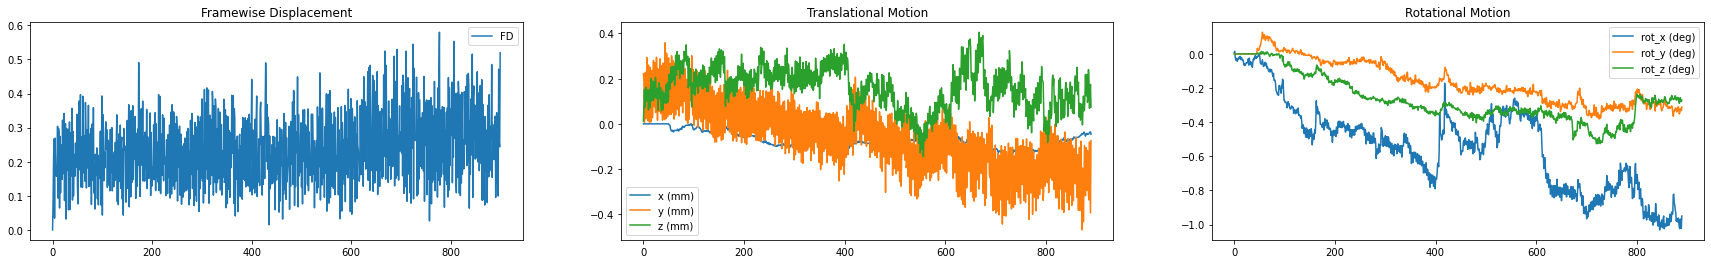

In [7]:
fig,axs = plt.subplots(1,3,figsize=(30,4))
mot_fd.plot(title='Framewise Displacement', ax=axs[0])
mot_regs[['x (mm)','y (mm)','z (mm)']].plot(title='Translational Motion', ax=axs[1])
mot_regs[['rot_x (deg)','rot_y (deg)','rot_z (deg)']].plot(title='Rotational Motion', ax=axs[2])

* Load and Plot periods of eye closure

In [8]:
EC_info = pd.read_pickle('../Resources/EC_Segments_Info.pkl')
EC_info = EC_info[EC_info['Run']==sample_run]
this_run_EC = pd.DataFrame(index=np.arange(890),columns=['ET Trace'])
for r, row in EC_info.iterrows():
    this_run_EC.loc[int(row.Onset):int(row.Offset)] = 1

<AxesSubplot:title={'center':'Eye Closure Periods'}, xlabel='index', ylabel='ET Trace'>

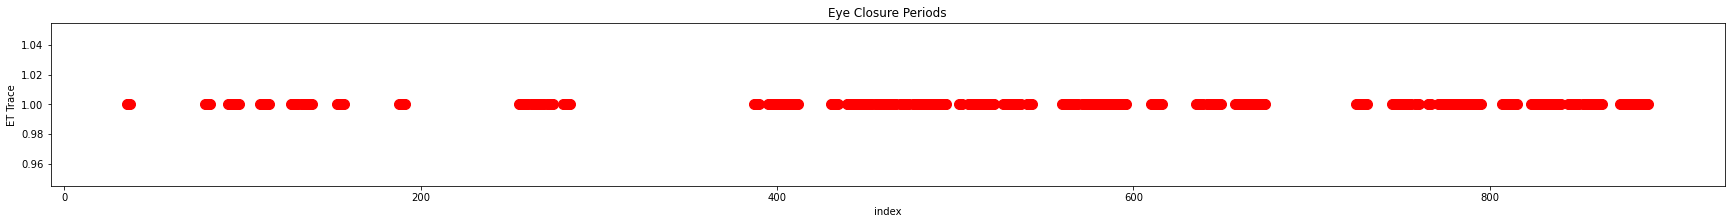

In [9]:
this_run_EC.reset_index().plot(x='index',y='ET Trace', kind='scatter',s=100, title='Eye Closure Periods', c='r', figsize=(30,3))

* Generate actual Figure 3

/data/SFIMJGC_HCP7T/Apps/envs/hcp7t_fv_sleep_env/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  del sys.path[0]


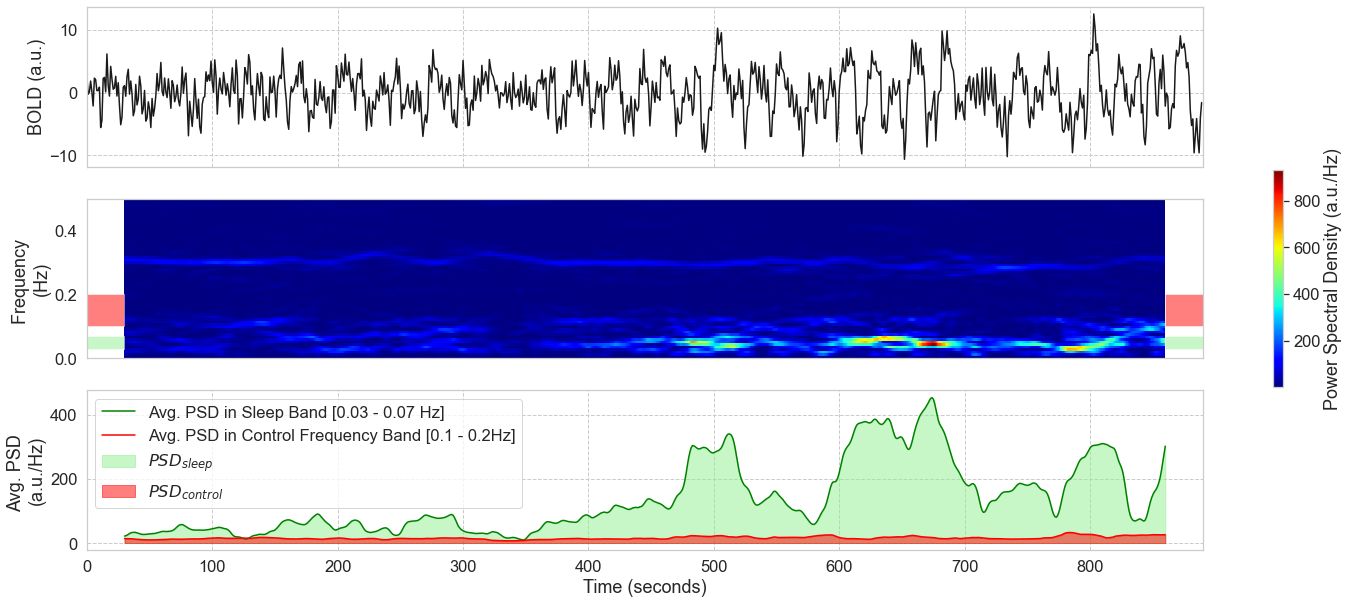

In [10]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid",{"xtick.major.size": 0.1,
    "xtick.minor.size": 0.05,'grid.linestyle': '--'})

fig, axes = plt.subplots(nrows=3, sharex=True, figsize=(25,10))

# Plot BOLD Timeseries
axes[0].plot(time_index.total_seconds(), sample_roi_df, 'k')
axes[0].set_xlim(0,890)
axes[0].set_ylabel('BOLD (a.u.)')
# ADD EYE CLOSURE PERIODS: axes[0].plot(time_index.total_seconds(), 12*this_run_EC['ET Trace'].values, 'ro')
# Plot Spectrogram
im = axes[1].pcolormesh(windowed_time_index.total_seconds(),sample_spectrogram_df.index, sample_spectrogram_df, cmap='jet')
axes[1].set_ylabel('Frequency \n(Hz)')
rect01 = plt.Rectangle((0,   0.03), 30, 0.04, facecolor='lightgreen', alpha=0.5); axes[1].add_patch(rect01)
rect02 = plt.Rectangle((860, 0.03), 30, 0.04, facecolor='lightgreen', alpha=0.5); axes[1].add_patch(rect02)

rect03 = plt.Rectangle((0,   0.1), 30, 0.1, facecolor='red', alpha=0.5); axes[1].add_patch(rect03)
rect04 = plt.Rectangle((860, 0.1), 30, 0.1, facecolor='red', alpha=0.5); axes[1].add_patch(rect04)

axes[1].set_ylim([0,0.5])
fig.colorbar(im, ax=axes[:], shrink=0.4, label='Power Spectral Density (a.u./Hz)')

# Plot Average PSD
PSD_sleep   = axes[2].plot(windowed_time_index.total_seconds(),sample_spectrogram_bl_df['sleep'],c='green')
PSD_control = axes[2].plot(windowed_time_index.total_seconds(),sample_spectrogram_bl_df['non_sleep'],c='red')
axes[2].fill_between(windowed_time_index.total_seconds(),sample_spectrogram_bl_df['sleep'],0, color='lightgreen', alpha=0.5)
axes[2].fill_between(windowed_time_index.total_seconds(),sample_spectrogram_bl_df['non_sleep'],0, color='red', alpha=0.5)
axes[2].set_xlabel('Time (seconds)')
axes[2].set_ylabel('Avg. PSD \n(a.u./Hz)')
axes[2].legend(['Avg. PSD in Sleep Band [0.03 - 0.07 Hz]','Avg. PSD in Control Frequency Band [0.1 - 0.2Hz]','$PSD_{sleep}$','$PSD_{control}$'])

In [11]:
fig.savefig('./figures/Fig03_PSDexplanation.png')

***
# Figure 6: Evolution of PSD across scan types

### Load list of runs classified as awake and drowsy

In [12]:
%%time
Manuscript_Runs = get_available_runs(when='final', type='all')
Awake_Runs      = get_available_runs(when='final', type='awake')
Drowsy_Runs     = get_available_runs(when='final', type='drowsy')

print('++ INFO: Number of Runs: Total = %d | Awake = %d | Drowsy = %d' % (len(Manuscript_Runs), len(Awake_Runs), len(Drowsy_Runs)))

++ INFO: Number of Runs: Total = 404 | Awake = 210 | Drowsy = 194
CPU times: user 4.32 ms, sys: 1.21 ms, total: 5.53 ms
Wall time: 5.25 ms


***
### Load PSD in Sleep Band

This data is already the result of a windowing operation (computation of the spectrogram). As such, we ensure the index has the correct values corresponding to windowed information

In [13]:
%%time
sleep_psd_DF = pd.DataFrame(index=windowed_time_index, columns=Manuscript_Runs)
ctrol_psd_DF = pd.DataFrame(index=windowed_time_index, columns=Manuscript_Runs)

for sbj_run in Manuscript_Runs:
    sbj,run = sbj_run.split('_',1)
    file    = '{RUN}_mPP.Signal.{REGION}.Spectrogram_BandLimited.pkl'.format(RUN=run, REGION=region)
    path    = osp.join(DATA_DIR,sbj,run,file)
    aux     = pd.read_pickle(path)
    sleep_psd_DF.loc[(windowed_time_index,sbj_run)] = aux['sleep'].values
    ctrol_psd_DF.loc[(windowed_time_index,sbj_run)] = aux['control'].values

sleep_psd_cumsum_DF = sleep_psd_DF.cumsum()
ctrol_psd_cumsum_DF = ctrol_psd_DF.cumsum()

print('++ INFO: Shape of PSD Dataframe [sleep_psd_DF] is %s' % str(sleep_psd_DF.shape))

++ INFO: Shape of PSD Dataframe [sleep_psd_DF] is (831, 404)
CPU times: user 543 ms, sys: 50.4 ms, total: 593 ms
Wall time: 615 ms


### Prepare PSD Dataframes for plotting with Seaborn & Compute Cumulative Version of PSD Estimates

***
## Load GS timeseries

In [15]:
%%time
GS_df = pd.DataFrame()
for item in Manuscript_Runs:
    sbj,run  = item.split('_',1)
    aux_path = osp.join(DATA_DIR,sbj,run+'_mPP','{RUN}_mPP.Signal.FB.1D'.format(RUN=run))
    aux_data = np.loadtxt(aux_path)
    assert aux_data.shape[0] == Nacq, "{file} has incorrect length {length}".format(file=aux_path, length=str(aux_data.shape[0]))
    GS_df[item] = aux_data

CPU times: user 1.09 s, sys: 76.6 ms, total: 1.16 s
Wall time: 6.45 s


### Save into a single Dataframe Object for Plotting

In [17]:
df_cum_plot = pd.concat([sleep_psd_cumsum_stacked_DF,ctrol_psd_cumsum_stacked_DF])
df_plot = pd.concat([sleep_psd_stacked_DF,ctrol_psd_stacked_DF])

### Plot the data

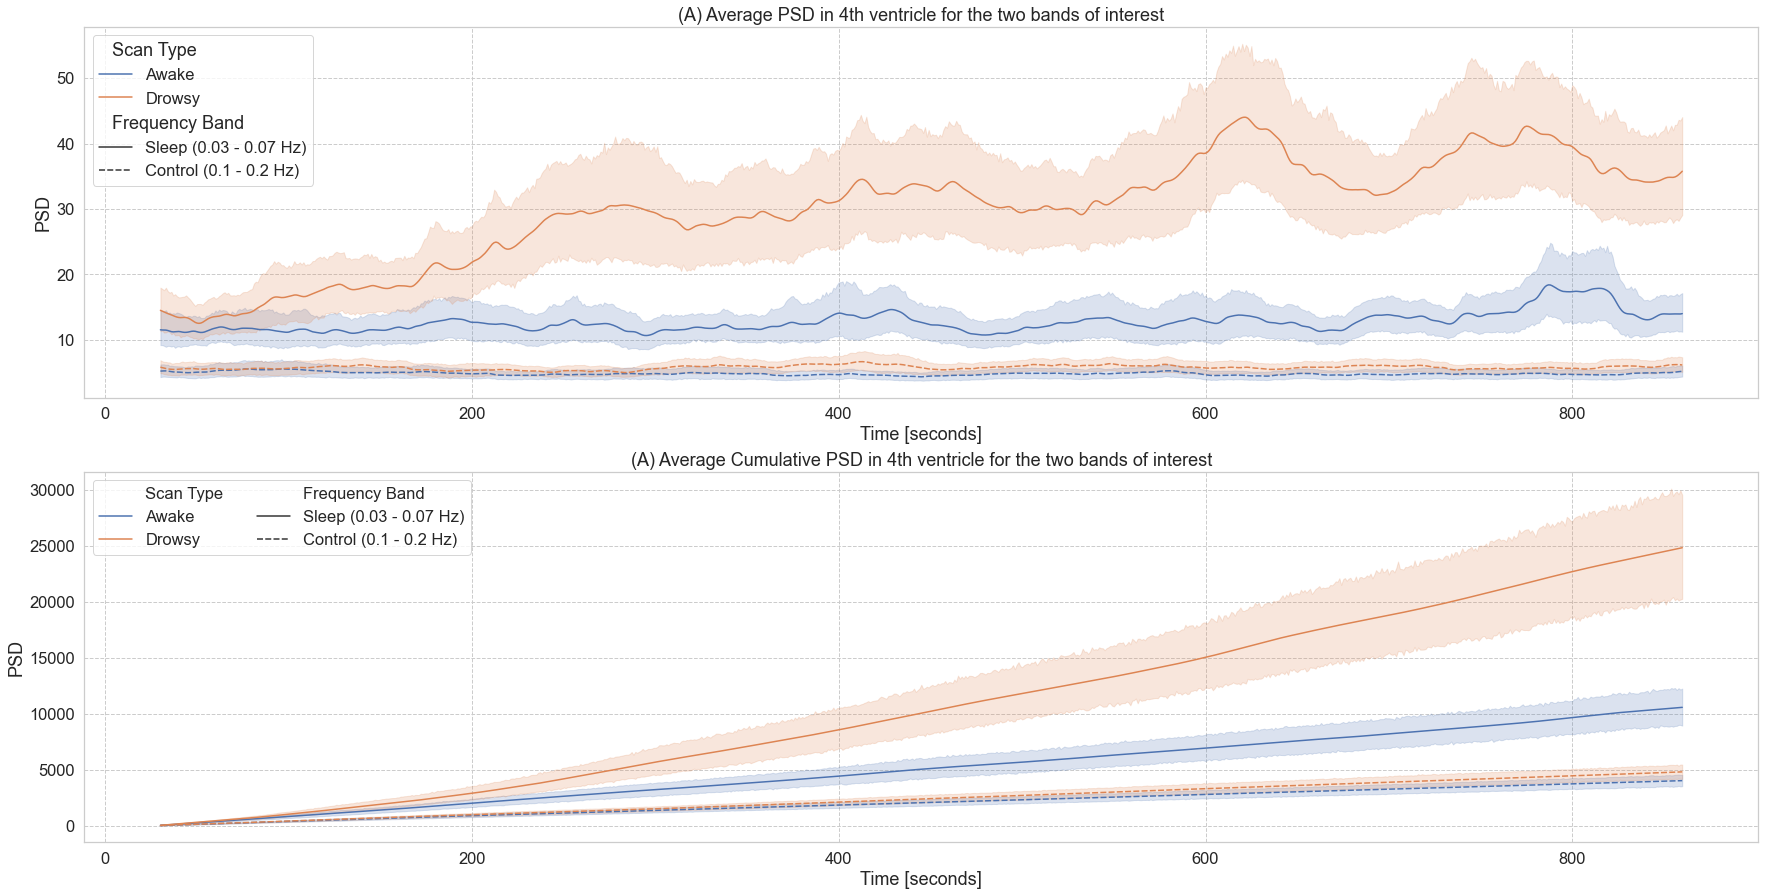

In [18]:
fig, ax = plt.subplots(2,1,figsize=(30,15))
sns.lineplot(data=df_plot, x='Time [seconds]', hue='Scan Type', y='PSD', style='Frequency Band', style_order=['Sleep (0.03 - 0.07 Hz)','Control (0.1 - 0.2 Hz)'], estimator=np.mean, n_boot=1000, ax=ax[0])
ax[0].set_title('(A) Average PSD in 4th ventricle for the two bands of interest')
sns.lineplot(data=df_cum_plot, x='Time [seconds]', hue='Scan Type', y='PSD', style='Frequency Band', style_order=['Sleep (0.03 - 0.07 Hz)','Control (0.1 - 0.2 Hz)'], estimator=np.mean, n_boot=1000, ax=ax[1])
ax[1].set_title('(A) Average Cumulative PSD in 4th ventricle for the two bands of interest')
ax[1].legend(ncol=2)

In [19]:
fig.savefig('./figures/Fig06_PSDacrossTime.png')